<a href="https://colab.research.google.com/github/PrathibhaNishadi/Flu-Shot-Learning/blob/main/Flu_Shot_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd


pd.set_option("display.max_columns", 100)

from google.colab import drive

drive.mount('/content/gdrive')
DATA_PATH = "/DataFiles/"
features_df = pd.read_csv(
    DATA_PATH + "training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    DATA_PATH + "training_set_labels.csv", 
    index_col="respondent_id"
)

test_features_df = pd.read_csv(DATA_PATH + "test_set_features.csv", 
                               index_col="respondent_id")
print("features_df.shape", features_df.shape)
features_df.head()
features_df.dtypes
print("labels_df.shape", labels_df.shape)
labels_df.head()

np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

In [ ]:
labels_df.info()

In [ ]:
features_df.info()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

Convert age into categorical values

In [ ]:
def change_age_group_column(x):
  if x['age_group'] == "18 - 34 Years":
    return 1
  elif x['age_group'] == "35 - 44 Years":
    return 2
  elif x['age_group'] == "45 - 54 Years":
    return 3
  elif x['age_group'] == "55 - 64 Years":
    return 4
  elif x["age_group"] == "65+ Years":
    return 5
  else: 
    return float("nan")

features_df['age_group'] = features_df.apply(lambda x : change_age_group_column(x),axis=1)
test_features_df['age_group'] = test_features_df.apply(lambda x : change_age_group_column(x),axis=1)



In [3]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values

In [4]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])

Fill the missing values from Inputer and onehot encoding for prepare a numeric array for the numerical categorical values

In [5]:
cat_cols = features_df.columns[features_df.dtypes == "object"].values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [6]:
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("cat", categorical_transformer,cat_cols)
    ],
    remainder = "drop"
)

In [ ]:
!pip install catboost

Import the relevent classifiers and libraries

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold,  KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

Use a ensemble model for higher accuracy. Can use the commented classifiers as well and tune the parameters for higher accuracies

In [ ]:
level0Class = list()

level0Class.append(('xg',XGBClassifier(n_estimators=251, max_depth=4, learning_rate=0.10, colsample_bytree=0.2,reg_lambda=1, silent=False)))
#level0Class.append(('rf',RandomForestClassifier()))
#level0Class.append(('svm',svm.SVC()))
#level0Class.append(('mlp',MLPClassifier()))
#level0Class.append(('ada', AdaBoostClassifier()))
level0Class.append(('ctb',CatBoostClassifier(learning_rate=0.10)))


#mettaclassifier

level1Class = LogisticRegression(penalty="l2")

estimators = StackingClassifier(estimators= level0Class, final_estimator= level1Class, cv=5)
estimators.get_params

Put the model in a multi output classifier

In [ ]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", MultiOutputClassifier(estimators)),
])
full_pipeline

Split the training data set for train and evaluation and fit to the model to train

In [16]:

X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=6
)

In [ ]:
full_pipeline.fit(X_train, y_train)

Predict on evaluation set. Output is a probability

In [19]:

preds = full_pipeline.predict_proba(X_eval)
preds
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.503430,0.657059
16516,0.066649,0.384970
3106,0.070381,0.686752
16981,0.914091,0.915841
19111,0.068146,0.702695


Plot the accuracy of the predicted evaluation dataset

0.8672809725599737

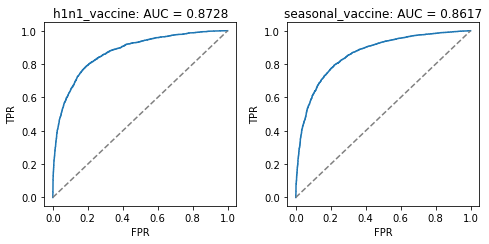

In [20]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()
roc_auc_score(y_eval, y_preds)

In [ ]:
full_pipeline.fit(features_df, labels_df)

Use the test dataset for prediction

In [ ]:
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.9175971 , 0.0824029 ],
        [0.94055103, 0.05944897],
        [0.8283482 , 0.1716518 ],
        ...,
        [0.85249015, 0.14750985],
        [0.94434483, 0.05565517],
        [0.39644896, 0.60355104]]), array([[0.70962644, 0.29037356],
        [0.92538557, 0.07461443],
        [0.2181173 , 0.7818827 ],
        ...,
        [0.83815121, 0.16184879],
        [0.77939353, 0.22060647],
        [0.38902829, 0.61097171]])]

In [ ]:
submission_df = pd.read_csv(DATA_PATH + "submission_format.csv", 
                            index_col="respondent_id")
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

Print the results into a csv

In [ ]:
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.082403,0.290374
26708,0.059449,0.074614
26709,0.171652,0.781883
26710,0.759892,0.881681
26711,0.283816,0.370688


In [ ]:
submission_df.to_csv(DATA_PATH + 'my_submission.csv', index=True)